In [3]:
from grimsel.core.io import IO
import numpy as np
import pandas as pd
import grimsel.core.model_loop as model_loop
from grimsel.core.model_base import ModelBase as MB
from grimsel import logger
logger.setLevel(0)

/mnt/data/miniconda/envs/grimsel/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
> 17:35:06 - WARNING - grimsel_config - Could not import BASE_DIR path.
> 17:35:06 - ERROR - grimsel_config - 
Please set configuration parameters in
grimsel/config_local.py, e.g.

import os
FN_XLSX = os.path.abspath('../DATA/input.xlsx')
DATABASE = 'database_name'
SCHEMA = 'model_input_schema_name'

PSQL_USER = 'user'
PSQL_PASSWORD = 'password'
PSQL_PORT = 5432
PSQL_HOST = 'localhost'



No module named 'config_local'
Using default csv path /mnt/data/Dropbox/GRIMSEL_SOURCE/grimsel/grimsel/input_data
No module named 'config_local'
No module named 'config_local'


In [4]:
df_def_node = pd.DataFrame({'nd': ['Node1'], 'nd_id':[0], 'price_co2': [80], 'nd_weight': [1]})
dict_nd = df_def_node.set_index('nd').nd_id.to_dict()
display(df_def_node)

,nd,nd_id,price_co2,nd_weight
0,Node1,0,80,1


In [5]:
df_def_fuel = pd.DataFrame({'fl_id': range(3),
                            'fl': ['natural_gas', 'hard_coal', 'wind'], 
                            'co2_int': [0.20196, 0.34596, 0]})
dict_fl = df_def_fuel.set_index('fl').fl_id.to_dict()
display(df_def_fuel)

,fl_id,fl,co2_int
0,0,natural_gas,0.20196
1,1,hard_coal,0.34596
2,2,wind,0.00000


In [6]:
df_def_encar = pd.DataFrame({'ca_id': [0],
                             'ca': ['EL']})
dict_ca = df_def_encar.set_index('ca').ca_id.to_dict()
display(df_def_encar)

,ca_id,ca
0,0,EL


In [7]:
df_def_pp_type = pd.DataFrame({'pt_id': range(3), 'pt': ['GAS_LIN', 'WIND', 'HCO_ELC']})
dict_pt = df_def_pp_type.set_index('pt').pt_id.to_dict()
display(df_def_pp_type)

,pt_id,pt
0,0,GAS_LIN
1,1,WIND
2,2,HCO_ELC


In [8]:
df_def_plant = pd.DataFrame({'pp': ['ND1_GAS_LIN', 'ND1_GAS_NEW', 'ND1_WIND', 'ND1_HCO_ELC'],
                             'pt_id': ['GAS_LIN', 'GAS_LIN', 'WIND', 'HCO_ELC'],
                             'nd_id': ['Node1'] * 4,
                             'fl_id': ['natural_gas', 'natural_gas', 'wind', 'hard_coal'],
                             'set_def_pr': [0, 0, 1, 0],
                             'set_def_pp': [1, 1, 0, 1],
                             'set_def_lin': [1, 0, 0, 0],
                             'set_def_add': [0, 1, 1, 0],
                            })
df_def_plant.index.name = 'pp_id'
df_def_plant = df_def_plant.reset_index()

# translate columns to id using the previously defined def tables
df_def_plant = df_def_plant.assign(pt_id=df_def_plant.pt_id.replace(dict_pt),
                                   nd_id=df_def_plant.nd_id.replace(dict_nd),
                                   fl_id=df_def_plant.fl_id.replace(dict_fl))
dict_pp = df_def_plant.set_index('pp').pp_id.to_dict()

display(df_def_plant)

,pp_id,pp,pt_id,nd_id,fl_id,set_def_pr,set_def_pp,set_def_lin,set_def_add
0,0,ND1_GAS_LIN,0,0,0,0,1,1,0
1,1,ND1_GAS_NEW,0,0,0,0,1,0,1
2,2,ND1_WIND,1,0,2,1,0,0,1
3,3,ND1_HCO_ELC,2,0,1,0,1,0,0


In [133]:
df_def_profile = pd.DataFrame({'pf_id': range(2),
                               'pf': ['SUPPLY_WIND', 'DMND_NODE1']})
dict_pf = df_def_profile.set_index('pf').pf_id.to_dict()
df_def_profile


,pf_id,pf
0,0,SUPPLY_WIND
1,1,DMND_NODE1


In [134]:
eff_gas_min = 0.4
eff_gas_max = 0.6
cap_gas = 4000.
f0_gas = 1/eff_gas_min
f1_gas = 1/cap_gas * (f0_gas - 1/eff_gas_max)


dr, lt = 0.06, 20 # assumed discount rate 6% and life time
fact_ann = ((1+dr)**lt * dr) / ((1+dr)**lt - 1)

fc_cp_gas = 800
fc_cp_gas_ann = fact_ann * fc_cp_gas

fc_cp_wind = 1500 # assumed capital cost wind power
fc_cp_wind_ann = fact_ann * fc_cp_wind

df_plant_encar = pd.DataFrame({'pp_id': ['ND1_GAS_LIN', 'ND1_GAS_NEW', 'ND1_WIND', 'ND1_HCO_ELC'],
                               'ca_id': ['EL'] * 4,
                               'supply_pf_id': [None, None, 'SUPPLY_WIND', None],
                               'pp_eff': [None, eff_gas_max, None, 0.4],
                               'factor_lin_0': [f0_gas, None, None, None],
                               'factor_lin_1': [f1_gas, None, None, None],
                               'cap_pwr_leg': [cap_gas, 0, 0, 5000],
                               'fc_cp_ann': [None, fc_cp_gas_ann, fc_cp_wind_ann, None],
                              })

df_plant_encar = df_plant_encar.assign(supply_pf_id=df_plant_encar.supply_pf_id.replace(dict_pf),
                                       pp_id=df_plant_encar.pp_id.replace(dict_pp),
                                       ca_id=df_plant_encar.ca_id.replace(dict_ca))
df_plant_encar



,pp_id,ca_id,supply_pf_id,pp_eff,factor_lin_0,factor_lin_1,cap_pwr_leg,fc_cp_ann
0,0,0,None,NaN,2.5,0.000208,4000.0,NaN
1,1,0,None,0.6,NaN,NaN,0.0,69.747646
2,2,0,0,NaN,NaN,NaN,0.0,130.776835
3,3,0,None,0.4,NaN,NaN,5000.0,NaN


In [135]:
df_node_encar = pd.DataFrame({'nd_id': ['Node1'], 'ca_id': ['EL'],
                              'dmnd_pf_id': ['DMND_NODE1']
                              })
df_node_encar = df_node_encar.assign(nd_id=df_node_encar.nd_id.replace(dict_nd),
                                     ca_id=df_node_encar.ca_id.replace(dict_ca),
                                     dmnd_pf_id=df_node_encar.dmnd_pf_id.replace(dict_pf))
df_node_encar

,nd_id,ca_id,dmnd_pf_id
0,0,0,1


In [136]:
df_fuel_node_encar = pd.DataFrame({'fl_id': ['natural_gas', 'hard_coal'],
                               'nd_id': ['Node1'] * 2,
                               'ca_id': ['EL'] * 2,
                               'vc_fl': [40, 10],
                              })
df_fuel_node_encar = df_fuel_node_encar.assign(fl_id=df_fuel_node_encar.fl_id.replace(dict_fl),
                                       nd_id=df_fuel_node_encar.nd_id.replace(dict_nd),
                                       ca_id=df_fuel_node_encar.ca_id.replace(dict_ca))
df_fuel_node_encar

,fl_id,nd_id,ca_id,vc_fl
0,0,0,0,40
1,1,0,0,10


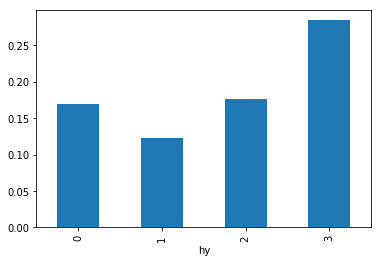

In [137]:
prf = [0.169, 0.122, 0.176, 0.284]

df_profsupply = pd.DataFrame({'supply_pf_id': [dict_pf['SUPPLY_WIND']] * len(prf),
                              'hy': range(len(prf)), 'value': prf})

df_profsupply.set_index('hy').value.plot.bar()

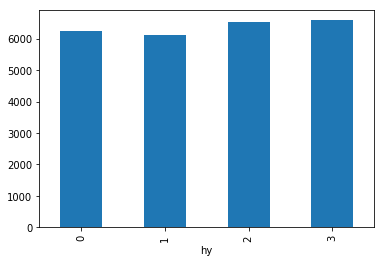

In [138]:
prf = [6248.5, 6109.0, 6531.6, 6579.4]

df_profdmnd = pd.DataFrame({'dmnd_pf_id': [dict_pf['DMND_NODE1']] * len(prf),
                            'hy': range(len(prf)), 'value': prf})

df_profdmnd.set_index('hy').value.plot.bar()

In [139]:
for dftb, tbname in [(df_def_node, 'def_node'),
                   (df_def_plant, 'def_plant'),
                   (df_def_fuel, 'def_fuel'),
                   (df_def_encar, 'def_encar'),
                   (df_node_encar, 'node_encar'),
                   (df_def_pp_type, 'def_pp_type'),
                   (df_plant_encar, 'plant_encar'),
                   (df_def_profile, 'def_profile'),
                   (df_fuel_node_encar, 'fuel_node_encar'),
                   (df_profsupply, 'profsupply'),
                   (df_profdmnd, 'profdmnd')]:
    dftb.to_csv('introductory_example_files/{}.csv'.format(tbname), index=False)
    

In [66]:
import os

mkwargs = {}
iokwargs = {'data_path': os.path.abspath('introductory_example_files/'),
            'output_target': 'hdf5',
            'cl_out': 'introductory_example_files/output.hdf5'}
nsteps = [('swco', 3, np.linspace),  # CO2 emission price
         ]
ml = model_loop.ModelLoop(nsteps=nsteps, mkwargs=mkwargs, iokwargs=iokwargs)
print(ml.io.datrd.data_path)

> 19:31:49 - ERROR - grimsel.core.io - 'No object named def_run in the file'
> 19:31:49 - WARNING - grimsel.core.io - reset_hdf_file: Could not determine max_run_id ... setting to None.



~~~~~~~~~~~~~~~   WARNING:  ~~~~~~~~~~~~~~~~
You are about to delete existing file introductory_example_files/output.hdf5.
The maximum run_id is None.

Hit enter to proceed.

/mnt/data/Dropbox/GRIMSEL_SOURCE/grimsel/notebooks/introductory_example_files


In [26]:
IO._close_all_hdf_connections()
ml.init_run_table()
ml.df_def_run

print(ml.io.datrd.data_path)


/mnt/data/Dropbox/GRIMSEL_SOURCE/grimsel/notebooks/introductory_example_files


Closing remaining open files:introductory_example_files/output.hdf5...done


In [27]:
logger.setLevel(1000)
ml.io.read_model_data()


In [28]:
ml.m.init_maps()

ml.m.map_to_time_res()


# %
ml.io.write_runtime_tables()

ml.m.get_setlst()
ml.m.define_sets()
ml.m.add_parameters()
ml.m.define_variables()
ml.m.add_all_constraints()
ml.m.init_solver()
ml.io.init_output_tables()
ml.select_run(0)
